# seq2seq translation 

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import time
import math
import pickle
from collections import Counter

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

In [3]:
USE_CUDA = False
data_dir = 'trans_data'
SOS_token = 0
EOS_token = 1

# 数据处理

### 单词管理的语言类

In [4]:
# class Lang(object):
#     '''某一语言的类，单词-编码，词频统计'''
    
#     def __init__(self, name):
#         self.name = name
#         self.word2index = {}
#         self.word2count = {}
#         self.index2word = {0: 'SOS', 1: "EOS"}
#         self.n_words = 2
    
#     def index_words(self, sentence):
#         ''' 为语言类添加一句话
#         Args:
#             sentence: 话，字符串，经过处理后的，以空格分割
#         '''
#         for word in sentence.split(' '):
#             self.index_word(word)
    
#     def index_word(self, word):
#         '''添加一个词汇'''
#         if word not in self.word2index:
#             idx = self.n_words
#             self.word2index[word] = idx
#             self.word2count[word] = 1
#             self.index2word[idx] = word
#             self.n_words += 1
#         else:
#             self.word2count[word] += 1

In [5]:
class Lang(object):
    '''某一语言的辅助类，word2index, index2word, 词频等'''
    def __init__(self, name):
        self.name = name
        self.init_params()
    
    def init_params(self, trimmed = False):
        '''初始化参数'''
        # 修整标记
        self.trimmed = trimmed
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0:"PAD", 1:"SOS", 2:"EOS"}
        self.n_words = 3
    
    def index_word(self, word):
        '''添加一个词语'''
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
    
    def index_sentence(self, sentence, split_str=' '):
        '''添加一句话
        Args:
            sentence: 字符串，单词以空格分割
            split_str: 字符串单词分隔符，默认是空格
        '''
        for word in sentence.split(split_str):
            self.index_word(word)
    
    def index_words(self, words):
        '''添加词汇列表
        Args:
            words: 词汇列表
        '''
        for word in words:
            self.index_word(word)
    
    def trim(self, min_count):
        '''移除出现次数太少的单词
        Args:
            min_count: 最少出现次数
        '''
        if self.trimmed:
            return
        keep_words = []
        
        for word, count in self.word2count.items():
            if count >= min_count:
                keep_words.append(word)
        print ("keep words: %s / %s = %.4f" % (len(keep_words), self.n_words,
              len(keep_words) / self.n_words))
        
        # 重新更新参数，重新添加
        self.init_params(True)
        self.index_words(keep_words)

### 转码和规整化字符串

In [6]:
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )


def normalize_str(s):
    '''小写化，去首尾空格，去掉特殊字符，给标点符号加上空格'''
    s = unicode_to_ascii(s.lower().strip())
    # 给.!? 前面加上空格
    s = re.sub(r"([.!?！。，])", r" \1", s)
    # 把非字母和.!?的字符串用空格代替
    s = re.sub(r"[^a-zA-Z.!！。，?]+", r" ", s)
    return s

def normalize_str2(s):
    '''小写化，去首尾空格，去掉特殊字符，给标点符号加上空格'''
    s = unicode_to_ascii(s.lower().strip())
    # 标点
    s = re.sub(r"([.!?！。，])", r" \1", s)
    s = re.sub(r'[^\u4e00-\u9fa5a-zA-Z.,!?。，！？ ]', r' ', s)
    #print (s)
    s = re.sub(r'\s+', r" ", s).strip()
    return s

def test_normalize_str():
    s = 'nihao你好，&&~~··你 在 干嘛呀！。干。。'
    print (s)
    sn = normalize_str2(s)
    print (sn)
test_normalize_str()

nihao你好，&&~~··你 在 干嘛呀！。干。。
nihao你好 ， 你 在 干嘛呀 ！ 。干 。 。


### 读取数据

In [7]:
def read_lines(filename):
    '''读取filename中的内容，一行一行，转换为ascii码'''
    # io.open
    lines = open(filename, encoding = 'utf-8').read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]


def read_langs(filename, src_name = 'en', dst_name ='french', reverse=False):
    ''' 读取
    Args:
        filename: 文件的路径
        src_name: 源语言名称
        dst_name: 目标语言名称
        reverse: 是否翻转
    Returns:
        input_lang: 输入语言的对象，只初始化了名字
        target_lang: 输出语言的对象，只初始化了名字
        pairs: [[i1, o1], [i2, o2], ...] 字符串pair
    '''
    lines = read_lines(filename)
    # 每一行以'\t'分隔两种语言
    pairs = []
    for i, line in enumerate(lines):
        l, r = line.split('\t')
        l, r = normalize_str(l), normalize_str(r)
        pairs.append([l, r])
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(dst_name)
        target_lang = Lang(src_name)
    else:
        input_lang = Lang(src_name)
        target_lang = Lang(dst_name)
    return input_lang, target_lang, pairs


def test_read_langs():
    '''看下有几个pairs'''
    filename = 'trans_data/en-french.txt'
    input_lang, target_lang, pairs = read_langs(filename)
    print (len(pairs))

#test_read_langs()

### 选择简单数据

In [8]:
# 句子长度
MAX_LENGTH = 10
good_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def is_simple(pair, en_idx):
    ''' 选择简单的句子
    长度小于MAX_LENGTH。格式，英语满足上面的前缀格式
    Args:
        pair: [en_sentence, otherlang_sentence]
        en_idx: 英语所在的pair的位置，比如0或者1
    '''
    src, dst = pair[0].split(' '), pair[1].split(' ')
    return (len(src) < MAX_LENGTH and len(dst) < MAX_LENGTH 
            and pair[en_idx].startswith(good_prefixes))


def filter_pairs(pairs, en_idx):
    return [p for p in pairs if is_simple(p, en_idx)]

### 准备数据

In [9]:
def prepare_data(filename, src_name='english', dst_name='french', reverse = False):
    ''' 准备数据
    Args:
        filename: 数据对的文件
        src_name: 数据左边的语言
        dst_name: 数据右边的语言
        reverse: 默认(src-dst), 翻转则(dst-src)
    Returns:
        input_lang: 源语言 lang对象，name= src_name 或 dst_name (反转) 
        target_lang: 目标语言 lang对象，name= dst_name 或 src_name (反转) 
        pairs: [[i1, o1], [i2, o2], [i3, o3], ...]，都是字符串格式
    '''
    input_lang, target_lang, pairs = read_langs(filename, src_name, dst_name, reverse)
    en_idx = 0 if reverse is not True else 1
    print ("read %s lines" % len(pairs))
    pairs = filter_pairs(pairs, en_idx)
    print ("remain %s lines" % len(pairs))
    for p in pairs:
        input_lang.index_words(p[0])
        target_lang.index_words(p[1])
    print (input_lang.name, input_lang.n_words)
    print (target_lang.name, target_lang.n_words)
    return input_lang, target_lang, pairs

def test_read_langs():
    '''读取语言数据'''
    filename = 'trans_data/en-french.txt'
    input_lang, target_lang, pairs = prepare_data(filename, 'eng', 'fra', True)
    print (random.choice(pairs))

#test_read_langs()

### 加载数据

In [10]:
# filename = 'trans_data/en-french.txt'
# input_lang, target_lang, pairs = prepare_data(filename, 'eng', 'fra', True)
# langs = (input_lang, target_lang)

### 读取ai数据

In [11]:

en_file = '20170912/seg_en'
zh_file = '20170912/seg_zh'

input_lang = Lang('english')
target_lang = Lang('french')

enf = open(en_file, 'r')
zhf = open(zh_file, 'r')


pairs = []
idx = 0
total = 20000
print_every = 5000
for line in enf.readlines():
    line = normalize_str2(line)
    words = line.split(' ')
    input_lang.index_words(words)
    pairs.append([line])
    idx +=1
    if idx % print_every == 0:
        print ('read en:', idx)
    if idx == total:
        break
print ('finish: en:', idx)
idx = 0
for line in zhf.readlines():
    line = normalize_str2(line)
    words = line.split(' ')
    target_lang.index_words(words)
    pairs[idx].append(line)
    idx += 1
    if idx % print_every == 0:
        print ('read zn:', idx)
    if idx == total:
        break
print ('finish zh:', idx)
pairs_bak = pairs

read en: 5000
read en: 10000
read en: 15000
read en: 20000
finish: en: 20000
read zn: 5000
read zn: 10000
read zn: 15000
read zn: 20000
finish zh: 20000


In [12]:
# 统计句子长度的分布
en_lens = [ len(p[0].split(' ')) for p in pairs]
zh_lens = [ len(p[1].split(' ')) for p in pairs]
print (max(en_lens), max(zh_lens))
en_lens_c = Counter(en_lens)
zh_lens_c = Counter(zh_lens)
print (en_lens_c)
print (zh_lens_c)

34 27
Counter({7: 2016, 8: 2007, 9: 1981, 10: 1943, 6: 1898, 11: 1621, 12: 1491, 5: 1330, 13: 1181, 14: 915, 4: 906, 15: 753, 16: 545, 3: 354, 17: 350, 18: 247, 19: 166, 20: 103, 21: 54, 2: 43, 22: 32, 23: 24, 24: 16, 26: 9, 25: 8, 1: 3, 28: 2, 27: 1, 34: 1})
Counter({7: 2409, 6: 2307, 8: 2266, 5: 2215, 9: 1934, 10: 1566, 4: 1488, 11: 1416, 12: 1047, 3: 830, 13: 805, 14: 548, 15: 375, 16: 251, 17: 155, 2: 142, 18: 104, 19: 60, 21: 24, 20: 21, 22: 18, 1: 7, 23: 6, 24: 2, 25: 2, 26: 1, 27: 1})


In [13]:
en_min_count = 30
zh_min_count = 30
en_max_len = 100
zh_max_len = 100

en_d = dict(en_lens_c)
zh_d = dict(zh_lens_c)
en_d = sorted(en_d.items(), key = lambda d: d[0], reverse=True)
zh_d = dict(zh_lens_c)
zh_d = sorted(zh_d.items(), key = lambda d: d[0], reverse=True)
print (en_d)
print (zh_d)
for l, c in en_d:
    if c >= en_min_count:
        en_max_len = l
        break

for l, c in zh_d:
    if c >= zh_min_count:
        zh_max_len = l
        break

print ('en:', en_max_len, 'zh:', zh_max_len)

[(34, 1), (28, 2), (27, 1), (26, 9), (25, 8), (24, 16), (23, 24), (22, 32), (21, 54), (20, 103), (19, 166), (18, 247), (17, 350), (16, 545), (15, 753), (14, 915), (13, 1181), (12, 1491), (11, 1621), (10, 1943), (9, 1981), (8, 2007), (7, 2016), (6, 1898), (5, 1330), (4, 906), (3, 354), (2, 43), (1, 3)]
[(27, 1), (26, 1), (25, 2), (24, 2), (23, 6), (22, 18), (21, 24), (20, 21), (19, 60), (18, 104), (17, 155), (16, 251), (15, 375), (14, 548), (13, 805), (12, 1047), (11, 1416), (10, 1566), (9, 1934), (8, 2266), (7, 2409), (6, 2307), (5, 2215), (4, 1488), (3, 830), (2, 142), (1, 7)]
en: 22 zh: 19


In [14]:
def filter_pairs(pairs):
    '''筛选长度合法的pair，两种语言句子都要满足长度'''
    remained = []
    for p in pairs:
        if len(p[0].split(' ')) <= en_max_len and len(p[1].split(' ')) <= zh_max_len:
            remained.append(p)
    return remained
new_pairs = filter_pairs(pairs)
print ('%s - %s, %.4f' % (len(pairs), len(new_pairs), len(new_pairs) / len(pairs)))
pairs = new_pairs

20000 - 19884, 0.9942


In [15]:
MIN_COUNT = 2
input_lang.trim(MIN_COUNT)
keep_pairs = []
for p in pairs:
    input_sentence = p[0]
    keep_input = True
    
    for word in input_sentence.split(' '):
        if word not in input_lang.word2index:
            keep_input = False
            break
    if keep_input:
        keep_pairs.append(p)

info = 'Pairs raw:%s, now:%s, %.4f remain' % (len(pairs), len(keep_pairs), len(keep_pairs) / len(pairs))
print (info)
old_pairs = pairs
print (len(old_pairs), len(keep_pairs))
pairs = keep_pairs

keep words: 5762 / 12187 = 0.4728
Pairs raw:19884, now:14791, 0.7439 remain
19884 14791


In [15]:
print (pairs[0][0])
langs = (input_lang, target_lang)
MAX_LENGTH = zh_max_len

a pair of red crowned cranes have staked out their nesting territory


### 把数据转换成Tensor和Variable

In [16]:
def indics_from_sentence(lang, sentence):
    ''' 获得句子的词汇的id列表
    Args:
        lang: sentence所在的语言对象
        sentence: 一句话
    Returns:
        [] 句子中单词的id列表
    '''
    return [lang.word2index[word] for word in sentence.split(' ')]


def variable_from_sentence(lang, sentence):
    ''' 获得一个句子的单词id组成的Variable
    Rertuns:
        indics_variable: 句子的单词的id列表，由Variable表示，(len, 1)
    '''
    indics = indics_from_sentence(lang, sentence)
    indics.append(EOS_token)
    # 训练模型，使用Variable作为输入，因为Variable可以跟踪计算图，自动计算梯度
    indics_variable = Variable(torch.LongTensor(indics).view(-1, 1))
    if USE_CUDA:
        indics_variable = indics_variable.cuda()
    return indics_variable


def variables_from_pair(langs, pair):
    '''
    Args:
        langs: 两个语言对象List，(input_lang, target_lang)
        pair: 一组句子list，(输入句子, 目标句子)
    '''
    input_variable = variable_from_sentence(langs[0], pair[0])
    target_variable = variable_from_sentence(langs[1], pair[1])
    return (input_variable, target_variable)


def test_variables_from_pair():
    '''选择一个pair，打印出相应的句子的单词id列表'''
    pair_var = variables_from_pair(langs, pairs[2])
    print (pair_var)

test_variables_from_pair()

(Variable containing:
    3
   29
    5
   30
   31
   32
   33
   34
   35
   36
   28
    1
[torch.LongTensor of size 12x1]
, Variable containing:
    3
   26
   27
   28
    9
   29
   25
    1
[torch.LongTensor of size 8x1]
)


### UTILS

In [17]:
def get_variable(tensor):
    ''' 直接获得variable，后面不用在判断，使用GPU或者不使用
    '''
    var = Variable(tensor)
    if USE_CUDA:
        var = var.cuda()
    return var

# 网络模型

### Encoder

In [18]:
class EncoderRNN(nn.Module):
    '''input-embed-gru'''
    def __init__(self, vocab_size, hidden_size, n_layers=1):
        '''
        Args:
            vocab_size: 输入语言的词汇表大小
            hidden_size: GRU的输入输出维数，词向量的维数
            n_layers: GRU的层数
        '''
        super(EncoderRNN, self).__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
    
    def forward(self, word_inputs, hidden):
        '''
        1. word_inputs > embedded
        2. embedded > GRU > output, hidden
        Args:
            word_inputs: 输入的单词id列表，可以是1个或者多个
            hidden: [n_layers, 1, hidden_size]
        Returns:
            output: [seq_len, 1, h_size]
            hidden: [n_layers, 1, h_size]
        '''
        seq_len = len(word_inputs)
        embedded = self.embedding(word_inputs).view(seq_len, 1, -1)
        output, hidden = self.gru(embedded, hidden)
        return output, hidden
    
    def init_hidden(self):
        '''初始化hidden'''
        hidden = get_variable(torch.zeros(self.n_layers, 1, self.hidden_size))
        return hidden

### Attn

In [19]:
class Attn(nn.Module):
    '''计算对齐向量'''
    def __init__(self, score_type, hidden_size, max_length = MAX_LENGTH):
        '''
        Args:
            score_type: 计算score的方法，'dot', 'general', 'concat'
            hidden_size: Encoder和Decoder的hidden_size
            max_length: 
        '''
        super(Attn, self).__init__()
        
        self.score_type = score_type
        self.hidden_size = hidden_size
        self.max_length = max_length
        if score_type == 'general':
            self.attn = nn.Linear(hidden_size, hidden_size)
        elif score_type == 'concat':
            self.attn = nn.Linear(hidden_size * 2, hidden_size)
            self.other = nn.Parameter(torch.FloatTensor(1, hidden_size))
    
    def score(self, hidden, encoder_output):
        ''' 计算Decoder中LSTM的ht与Encoder中的hs的得分，便于后面算对齐概率
        Args:
            hidden: Decoder中最顶层LSTM的隐状态，h_de_t，[1, h_size]
            encoder_output: Encoder某时刻的隐状态，h_en_s，[1, h_size]
        Returns:
            energy: d_ht与e_hs的得分，即Yt与Xs的得分
        '''
        # dot 需要两个1维的向量
        if self.score_type == 'dot':
            energy = hidden.squeeze(0).dot(encoder_output.squeeze(0))
        elif self.score_type == 'general':
            energy = self.attn(encoder_output)
            #print('energy:', energy.size(), 'hidden:', hidden.size())
            energy = hidden.squeeze(0).dot(energy.squeeze(0))
        elif self.score_type == 'concat':
            h_o = torch.cat((hidden, encoder_output), 1)
            energy = self.attn(h_o)
            energy = self.other.squeeze(0).dot(energy.squeeze(0))
        return energy
    
    def forward(self, hidden, encoder_outputs):
        ''' 时刻t，计算对齐向量
        Args:
            hidden: Top LSTM的隐状态
            encoder_outputs: Encoder的所有隐状态, len=Tx输入句子长度
        Returns:
            align_vec: 当前ht与所有encoder_outputs的对齐向量，alpha_t，len=Tx，返回[1, 1, seq_len]格式
        '''
        seq_len = len(encoder_outputs)
        attn_energies = get_variable(torch.zeros(seq_len))
        for i in range(seq_len):
            attn_energies[i] = self.score(hidden, encoder_outputs[i])
        # normalize [0, 1], resize to [1, 1, seq_len]
        align_vec = F.softmax(attn_energies)
        align_vec = align_vec.unsqueeze(0).unsqueeze(0)
        #print ('alignv:', type(align_vec))
        return align_vec

### AttnDecoderRNN

In [20]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1, score_type='general', dropout_p=0.1):
        ''' init
        Args:
            hidden_size: Embedding和GRU的hidden_size
            output_size: 输出的size，是目标语言的词典大小
            score_type: 'dot', 'general', 'concat'
            n_layers: GRU的层数
            dropout_p: dropout
        '''
        super(AttnDecoderRNN, self).__init__()
        # parameters
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.score_type = score_type
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        
        # layers
        self.embedding = nn.Embedding(output_size, hidden_size)
        # 注意input_size
        self.gru = nn.GRU(hidden_size * 2, hidden_size, n_layers, dropout = dropout_p)
        self.out = nn.Linear(hidden_size * 2, output_size)
        # 计算对齐向量
        self.attn = Attn(score_type, hidden_size)
    
    def forward(self, word_input, last_context, last_hidden, encoder_outputs):
        '''
        1. (word_embedded, last_context) > rnn_input
        2. rnn_input, last_hidden > GRU > rnn_output, hidden
        3. rnn_output, encoder_outputs > Attn > attn_weights
        4. attn_weights * encoder_outputs > context
        5. (rnn_output, context) > Out > Softmax > output
        Args:
            word_input: word_id
            last_context: [1, h]
            last_hidden: [1, 1, h]
            encoder_outputs: [seq_len, 1, h]
        Returns:
            output: [1, o_size]
            context: [1, h]
            hidden: [1, 1, h]
            attn_weights: [1, 1, inseq_len]
        '''
        # 当前input_word, 实际上是last output_word
        word_embedded = self.embedding(word_input).view(1, 1, -1)
        
        # 串联input_word和last_context作为GRU的输入
        rnn_input = torch.cat((word_embedded, last_context.unsqueeze(0)), 2)
        # 当前输入一个单词 (seq_len=1, b, h) (n_layers*n_dirs, b, h)
        rnn_output, hidden = self.gru(rnn_input, last_hidden)
        
        # 计算output与encoder_outputs的对齐向量 (1, 1, seq_len)
        attn_weights = self.attn(rnn_output.squeeze(0), encoder_outputs)
        #print (type(attn_weights), attn_weights)
        # 语义向量 (1, 1, seq_len) (1, seq_len, h) > (1, 1, h)
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
        
        # RNN h和context 输出output (1,1,h) > (1, h)
        rnn_output = rnn_output.squeeze(0)
        # (1, 1, h) > (1, h)
        context = context.squeeze(1)
        # (1, 2h)
        ro_c = torch.cat((rnn_output, context), 1)
        # (1, o_size)
        output = F.log_softmax(self.out(ro_c))
        return output, context, hidden, attn_weights

### 测试模型

In [21]:
def test_model():
    encoder = EncoderRNN(10, 10, 2)
    decoder = AttnDecoderRNN(10, 10, 2, score_type='general')
    print (encoder)
    print (decoder)
    encoder_hidden = encoder.init_hidden()
    word_inputs = get_variable(torch.LongTensor([1, 2, 3]))
    encoder_outputs, encoder_hidden = encoder(word_inputs, encoder_hidden)
    #print ('outputs:', encoder_outputs.size(), ', hidden:', encoder_hidden.size())
    
    attns = torch.zeros(1, 3, 3)
    hidden = encoder_hidden
    context = get_variable(torch.zeros(1, decoder.hidden_size))
    
    for i in range(3):
        output, context, hidden, attn_weights = decoder(word_inputs[i], context, hidden, encoder_outputs)
        print (output.size(), hidden.size(), attn_weights.size())
    
test_model()

EncoderRNN (
  (embedding): Embedding(10, 10)
  (gru): GRU(10, 10, num_layers=2)
)
AttnDecoderRNN (
  (embedding): Embedding(10, 10)
  (gru): GRU(20, 10, num_layers=2, dropout=0.1)
  (out): Linear (20 -> 10)
  (attn): Attn (
    (attn): Linear (10 -> 10)
  )
)
torch.Size([1, 10]) torch.Size([2, 1, 10]) torch.Size([1, 1, 3])
torch.Size([1, 10]) torch.Size([2, 1, 10]) torch.Size([1, 1, 3])
torch.Size([1, 10]) torch.Size([2, 1, 10]) torch.Size([1, 1, 3])


# 训练

In [22]:
teacher_forcing_ratio = 0.4
clip = 5.0

def train(inputv, targetv, encoder, decoder, 
          encoder_optimizer, decoder_optimizer, loss_func, max_length = MAX_LENGTH):
    # zero grad
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss = 0
    
    # 输入和输出句子长度
    input_len = inputv.size()[0]
    target_len = targetv.size()[0]
    
    # encoder
    encoder_hidden = encoder.init_hidden()
    encoder_outputs, encoder_hidden = encoder(inputv, encoder_hidden)
    
    # input and output variables
    decoder_input = get_variable(torch.LongTensor([[SOS_token]]))
    decoder_context = get_variable(torch.zeros(1, decoder.hidden_size))
    decoder_hidden = encoder_hidden
    
    use_teacher_forcing = random.random() < teacher_forcing_ratio
    
    if use_teacher_forcing:
        # 使用真实值作为输入
        for i in range(target_len):
            decoder_output, decoder_context, decoder_hidden, decoder_attention = \
                decoder(decoder_input, decoder_context, decoder_hidden, encoder_outputs)
            #print('******************', decoder_output[0].size(), targetv[i].size())
            loss += loss_func(decoder_output, targetv[i]) 
            decoder_input = targetv[i]
    else:
        # 使用网络预测的作为输入
        for i in range(target_len):
            decoder_output, decoder_context, decoder_hidden, decoder_attention = \
                decoder(decoder_input, decoder_context, decoder_hidden, encoder_outputs)
            #print('******************', decoder_output[0].size(), targetv[i].size())
            loss += loss_func(decoder_output, targetv[i]) 
            # 找到最有可能的词
            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0]
            decoder_input = get_variable(torch.LongTensor([[ni]]))
            if ni == EOS_token:
                break
    # bp
    loss.backward()
    torch.nn.utils.clip_grad_norm(encoder.parameters(), clip)
    torch.nn.utils.clip_grad_norm(decoder.parameters(), clip)
    encoder_optimizer.step()
    decoder_optimizer.step()
    return loss.data[0] / target_len

In [23]:
def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return ('%dm %ds') % (m, s)

def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / percent
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))

### 进行训练

In [24]:
score_type = 'general'
hidden_size = 500
n_layers = 2
dropout_p = 0.05
learning_rate = 0.0001

encoder = EncoderRNN(input_lang.n_words, hidden_size, n_layers)
decoder = AttnDecoderRNN(hidden_size, target_lang.n_words, n_layers=n_layers,
                         score_type=score_type, dropout_p=dropout_p)
print (encoder)
print (decoder)

encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
loss_func = nn.NLLLoss()

EncoderRNN (
  (embedding): Embedding(12187, 500)
  (gru): GRU(500, 500, num_layers=2)
)
AttnDecoderRNN (
  (embedding): Embedding(18197, 500)
  (gru): GRU(1000, 500, num_layers=2, dropout=0.05)
  (out): Linear (1000 -> 18197)
  (attn): Attn (
    (attn): Linear (500 -> 500)
  )
)


In [27]:
# 训练信息
n_epochs = int(50000*1.5)
plot_every = int(200*1.5)
print_every = int(500)

start = time.time()
plot_losses = []
print_loss_total = 0
plot_loss_total = 0
log_file = './seq2seq-enzh.log'
f = open(log_file, 'w')

In [ ]:
model_dir = 'models/en-zh-1015'
save_every = 20000

# 开始训练
for epoch in range(1, n_epochs+1):
    training_pair = variables_from_pair(langs, random.choice(pairs))
    inputv = training_pair[0]
    targetv = training_pair[1]
    loss = train(inputv, targetv, encoder, decoder, encoder_optimizer, decoder_optimizer, loss_func)
    
    # Keep track of loss
    print_loss_total += loss
    plot_loss_total += loss
    
    if epoch == 0: continue

    if epoch % print_every == 0:
        print_loss_avg = print_loss_total / print_every
        print_loss_total = 0
        print_summary = '%s (%d %d%%) %.4f' % (time_since(start, epoch / n_epochs), epoch, epoch / n_epochs * 100, print_loss_avg)
        print(print_summary)
        f.write(print_summary + '\n')

    if epoch % plot_every == 0:
        plot_loss_avg = plot_loss_total / plot_every
        plot_losses.append(plot_loss_avg)
        plot_loss_total = 0
    
    if epoch % save_every == 0:
        no = epoch / save_every
        to = n_epochs / save_every
        s = '{}_{}'.format(no, to)
        torch.save(encoder, model_dir + '/' + s + 'encoder.pkl')
        torch.save(encoder, model_dir + '/' + s + 'decoder.pkl')

# 保存模型
model_dir = 'models/en-zh-1015'
torch.save(encoder, model_dir + '/encoder.pkl')
torch.save(decoder, model_dir + '/decoder.pkl')

33m 49s (- 5039m 11s) (500 0%) 5.0958
106m 15s (- 5206m 54s) (1500 2%) 4.7210
143m 4s (- 5222m 28s) (2000 2%) 4.6681
180m 10s (- 5225m 6s) (2500 3%) 4.5910


In [96]:
encoder1 = torch.load(model_dir + '/encoder.pkl')
decoder1 = torch.load(model_dir + '/decoder.pkl')


def evaluate(sentence, input_lang, target_lang, encoder, decoder, max_length = MAX_LENGTH):
    inputv = variable_from_sentence(input_lang, sentence)
    input_length = inputv.size()[0]
    encoder_hidden = encoder.init_hidden()
    encoder_outputs, encoder_hidden = encoder(inputv, encoder_hidden)
    
    decoder_input = get_variable(torch.LongTensor([[SOS_token]]))
    decoder_context = get_variable(torch.zeros(1, decoder.hidden_size))
    decoder_hidden = encoder_hidden
    
    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)
    
     # 使用网络预测的作为输入
    for i in range(max_length):
        decoder_output, decoder_context, decoder_hidden, decoder_attention = \
            decoder(decoder_input, decoder_context, decoder_hidden, encoder_outputs)
        #print('******************', decoder_output[0].size(), targetv[i].size())
        # 找到最有可能的词
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        decoder_input = get_variable(torch.LongTensor([[ni]]))
        decoded_words.append(target_lang.index2word[ni])
        if ni == EOS_token:
            break
    return decoded_words

def evaluate_randomly(encoder, decoder, input_lang, target_lang):
    pair = random.choice(pairs)
    output_words = evaluate(pair[0], input_lang, target_lang, encoder1, decoder1)
    output_sentence = ' '.join(output_words)
    print ('raw:', pair[0])
    print ('tar:', pair[1])
    print ('now:', output_sentence)

for i in range(5):
    evaluate_randomly(encoder1, decoder1, input_lang, target_lang)
    print ('')

NameError: name 'model_dir' is not defined

In [ ]:
while(True):
    s = raw_input()
    s = unicode(s)
    s = normalize_str(s)
    output_words = evaluate(s, input_lang, target_lang, encoder1, decoder1)
    output_sentence = ' '.join(output_words)
    #print ('raw:', pair[0])
    #print ('tar:', pair[1])
    print ('now:', output_sentence)

Je t'aime
now: i m you you . EOS
J'ai besoin de toi
now: i m on you of you . EOS
J'ai faim
now: i m hungry hungry . EOS
Il avait faim
now: he s got hungry . EOS
Il est plein de nourriture
now: he is full of treachery . EOS
Il veut manger
now: he s a bad liar . EOS


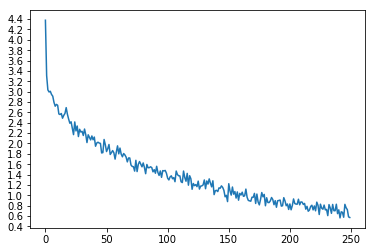

In [21]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2) # put ticks at regular intervals
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

show_plot(plot_losses)

In [7]:
output = open('trans_data/data_10000.pkl', 'rb')
bak = pickle.load(output)
train_en = bak['train_en']
train_len_en = bak['train_len_en']
train_zh = bak['train_zh']
train_len_zh = bak['train_len_zh']
output.close()

In [9]:
print (type(train_en))
print (train_en[0])

<type 'list'>
[113, 2438, 6, 747, 87447, 11, 87447, 15676, 17514, 17, 20000, 41, 88, 18581, 3308, 338352]
